# Using Azure Notebooks to run a Deep learning Keras model to classify fashion items

Looking to start building your own custom machine learning code using Deep Learning Libraries/Toolkits - [Keras](https://keras.io/) is a great high level API to use to do this.

In the code below we build a model from the Fashion MNIST dataset to classify clothing items into 10 categories. The data can be found here: https://github.com/zalandoresearch/fashion-mnist

Because we are using Azure Notebooks, all packages and frameworks are already installed on the free compute. So we only need to import the packages we need! 


* Import Tensorflow framework and Keras. As well as other more basic python packages

> You can change the backend used in Keras from Tensorflow to CNTK by simply changing the `os.environ['KERAS_BACKEND']` variable to `cntk`

In [11]:
import tensorflow as tf
import os
import time
from sklearn.metrics import confusion_matrix
os.environ["TF_CPP_MIN_LOG_LEVEL"]= "2"
print("tensorflow Version is: " + str(tf.__version__))

import numpy as np
os.environ['KERAS_BACKEND'] = 'tensorflow'
from keras import backend as K
print(os.environ['KERAS_BACKEND'])

tensorflow Version is: 1.12.0
tensorflow


* Import all the Keras functions we will need to use to create a Convolutional Neural Network (CNN)

In [2]:
#Fashion MNIST Dataset CNN model development: https://github.com/zalandoresearch/fashion-mnist
from keras.datasets import fashion_mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import utils, losses, optimizers
import matplotlib.pyplot as plt

* We setup some variables for example how many classes there are [0-9] as well as batch size to send the training sample of data in to the model and epochs is how many iterations/run thoroughs of the data there are
* Each image is of size 28 x 28 pixels

In [3]:
#no. of classes
num_classes = 10

# batch size and training iterations (epochs)
batch_size = 128
epochs = 10

#input image dimensions
img_rows,img_cols = 28,28

* In this section lets have a look at the data
* we pull in the fashion MNIST data from the Keras library into training and testing sets
* X stands for features and y stands for labels
* From the shape statements in the output you can see there are 60,000! training images and 10,000 test images - so a lot more data to use in this model
* We then show one of the images from the training set and the corresponding text label for the image

> change the img_index field to any number between 0 - 60000 to see different images

(60000, 28, 28) train set
(10000, 28, 28) test set
Label Index: 9 Fashion Labels: Ankle boot


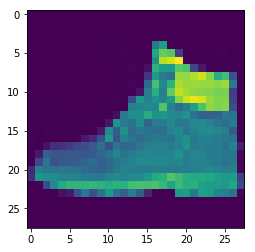

In [4]:
#data for train and testing
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

print(x_train.shape, 'train set')
print(x_test.shape, 'test set')

# Define the text labels
fashion_mnist_labels = ["Top",          # index 0
                        "Trouser",      # index 1
                        "Jumper",       # index 2 
                        "Dress",        # index 3 
                        "Coat",         # index 4
                        "Sandal",       # index 5
                        "Shirt",        # index 6 
                        "Trainer",      # index 7 
                        "Bag",          # index 8 
                        "Ankle boot"]   # index 9

img_index=90
label_index = y_train[img_index]
plt.imshow(x_train[img_index])
print('Label Index: ' + str(label_index) + " Fashion Labels: " + (fashion_mnist_labels[label_index]))

* In this section we normalise the data so the pixel values in the image are between 0 - 1 instead of 0 - 255 pixel values. This will help the model to converge and the math becomes easier with smaller numbers
* We also [one-hot-encode](https://www.quora.com/What-is-one-hot-encoding-and-when-is-it-used-in-data-science#) the labels in matrices with 0's and 1's in them only. We do this so the model does not deem any category 0-9 in a numeric ranking. For example it won't think that tshirts[0] always come before trousers[1] when actually these are IDs of the classes not something to be evaluated
* finally as we are deadling with greyscale images we have a depth number = 1 that might be interpreted different dpending on the framework used (CNTK, Tensorflow etc)

In [5]:
#type convert and scale the test and training data
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

#one-hot encoding
y_train = utils.to_categorical(y_train, num_classes)
y_test = utils.to_categorical(y_test,  num_classes)

#formatting issues for depth of image (greyscale = 1) with different kernels (tensorflow, cntk, etc)
if K.image_data_format()== 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0],1,img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols,1)
    x_test = x_test.reshape(x_test.shape[0],img_rows, img_cols,1)
    input_shape = (img_rows, img_cols,1)

Now we are able to define the Convolutional Neural Network (CNN) in layers

![CNN](cnn.JPG "CNN")

* This is a **sequential model** meaning every layer passes information forward to the next layer of the network
* **1st Convoltuional Layer** - extracts features from data source, these are kernels/filters and feature maps. Feature maps passed to the  next layer. This layer also has a ReLu activation function - Y = max(0, x) this removes any value <0 and prevents vanishing gradients or weights <0
* **2nd pooling layer ** - reduces dimensionality, reduce compute and helps with overfitting of the data.
* **3rd Convolutional Layer ** -we add a Convoltuional Layer - extracts features from data source, these are kernels/filters and feature maps. Feature maps passed to the  next layer. This layer also has a ReLu activation function - Y = max(0, x) this removes any value <0 and prevents vanishing gradients or weights <0
* **4th Pooling Layer ** - reduces dimensionality, reduce compute and helps with overfitting of the data.
* **5th/6th Dense fully connected layer with softmax function:** put features together and classify what item of clothing is used

> **Run some experiments to see how when you change the model below and rerun all the code the accuarcy and model will change:**
* add a dropout layer after the first pooling layer and also before the final dense layer: `model.add(Dropout(0.5))`
* change the value of dropout between 0 and 1: `model.add(Dropout(X))`
* change the 2 Conv2D layer first variable to 32 instead of 64: `model.add(Conv2D(32, kernel_size=(3,3), activation = 'relu'))`
* Add padding to each of the Conv2D layers: `model.add(Conv2D(32, kernel_size=(3,3), padding = 'same', activation = 'relu'))`

In [6]:
#Define the CNN model
model = Sequential()

model.add(Conv2D(64, kernel_size=(3,3), activation = 'relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, kernel_size=(3,3), activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))

model.add(Dense(num_classes, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 64)        640       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               204928    
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1290      
Total para

* This code compiles the CNN model and assigns loss/optimiser functions as well as metrics we wish to view
* I start a timer so we know how long the model takes to run
* Fit the training data to the model using 24 epoches and batches of 64 images. Pass in the test data as your validation set so we can see how the accuracy differs on the training set to the validation set as the model runs through 24 epochs
* Finally evaluate the model using the test/validation set

> Have a look at what optimisers are available in Keras and see what happens when you change this value: [https://keras.io/optimizers/](https://keras.io/optimizers/)

In [7]:
#compile - how to measure loss
model.compile(loss=losses.categorical_crossentropy, optimizer=optimizers.Adam(), metrics=['accuracy'])

#train the model and return loss and accuracy for each epoch - history dictionary
start = time.time()
hist = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(x_test, y_test))
end = time.time()

#evaluate the model on the test data
score = model.evaluate(x_test, y_test, verbose=0)
print('Test Loss: ', score[0])
print('Test Accuracy: ', score[1])
print('Time to run: ', (end-start))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 53s 875us/step - loss: 0.5351 - acc: 0.8071 - val_loss: 0.3906 - val_acc: 0.8597
Epoch 2/10
60000/60000 [==============================] - 50s 836us/step - loss: 0.3404 - acc: 0.8757 - val_loss: 0.3247 - val_acc: 0.8838
Epoch 3/10
60000/60000 [==============================] - 50s 826us/step - loss: 0.2918 - acc: 0.8945 - val_loss: 0.3113 - val_acc: 0.8866
Epoch 4/10
60000/60000 [==============================] - 50s 837us/step - loss: 0.2626 - acc: 0.9047 - val_loss: 0.2867 - val_acc: 0.8973
Epoch 5/10
60000/60000 [==============================] - 43s 717us/step - loss: 0.2412 - acc: 0.9111 - val_loss: 0.2709 - val_acc: 0.9032
Epoch 6/10
60000/60000 [==============================] - 28s 470us/step - loss: 0.2191 - acc: 0.9198 - val_loss: 0.2721 - val_acc: 0.9006
Epoch 7/10
60000/60000 [==============================] - 25s 421us/step - loss: 0.2041 - acc: 0.9242 - val_loss: 0.

* This code plots the training and validation accuracy across 24 epochs
* The training accuracy is often higher but the validation accuracy is deemed a more real world value

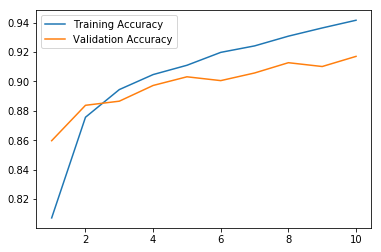

In [8]:
epoch_list = list(range(1, len(hist.history['acc']) + 1))
plt.plot(epoch_list, hist.history['acc'], epoch_list, hist.history['val_acc'])
plt.legend(('Training Accuracy', "Validation Accuracy"))
plt.show()

Margaret Maynard Reid shows us a great way to visualise a sample set output of the test results here: [https://medium.com/tensorflow/hello-deep-learning-fashion-mnist-with-keras-50fcff8cd74a](https://medium.com/tensorflow/hello-deep-learning-fashion-mnist-with-keras-50fcff8cd74a)

Run this code to see a set of 15 images from the test set and whether the labels are assigned correctly

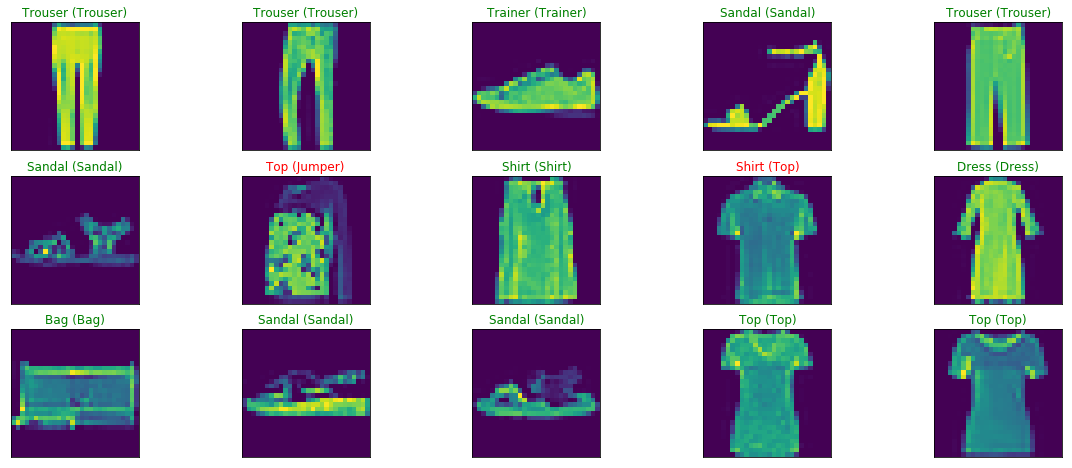

In [9]:
predictions = model.predict(x_test)

# Plot a random sample of 10 test images, their predicted labels and ground truth
figure = plt.figure(figsize=(20, 8))
for i, index in enumerate(np.random.choice(x_test.shape[0], size=15, replace=False)):
    ax = figure.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    # Display each image
    ax.imshow(np.squeeze(x_test[index]))
    predict_index = np.argmax(predictions[index])
    true_index = np.argmax(y_test[index])
    # Set the title for each image
    ax.set_title("{} ({})".format(fashion_mnist_labels[predict_index], 
                                  fashion_mnist_labels[true_index]),
                                  color=("green" if predict_index == true_index else "red"))

In [12]:
#Correlation Matrix
y_pred = model.predict(x_test)
print(y_pred.shape)
y_prediction = np.zeros(shape = (10000,10))

#print(y_prediction)
count = 0

for x in y_pred:
    index = np.argmax(x)
    y_prediction[count, index] = 1
    count = count + 1
    
print(fashion_mnist_labels)
confusion_matrix(y_test.argmax(axis=1), y_prediction.argmax(axis=1))

(10000, 10)
['Top', 'Trouser', 'Jumper', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Trainer', 'Bag', 'Ankle boot']


array([[902,   0,  12,  10,   2,   1,  70,   0,   3,   0],
       [  4, 977,   1,  11,   2,   0,   3,   0,   2,   0],
       [ 27,   0, 868,   8,  48,   0,  47,   0,   2,   0],
       [ 22,   2,   6, 911,  30,   0,  24,   0,   5,   0],
       [  2,   1,  42,  15, 883,   0,  57,   0,   0,   0],
       [  0,   0,   0,   0,   0, 975,   0,  16,   0,   9],
       [127,   0,  55,  22,  58,   0, 730,   0,   8,   0],
       [  0,   0,   0,   0,   0,   6,   0, 965,   0,  29],
       [  2,   0,   3,   3,   2,   1,   1,   1, 987,   0],
       [  1,   0,   0,   0,   0,   5,   0,  21,   0, 973]])